In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gc
import glob

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False


# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

In [2]:
data_type = "train"
# month = "07"
# category = "잔액정보"

# local
root_path = '../data/open'

# colab
# root_path = '/content/drive/MyDrive/12조 파이널프로젝트/data'

drive_folder = f'{root_path}/{data_type}/5.잔액정보/'

In [3]:
pd.options.display.float_format = '{:.5f}'.format

In [7]:
# 잔액정보 (모든 월 통합) 통합 parquet
balance_eda = pd.read_parquet(f'{drive_folder}train_잔액정보_통합_전처리1.parquet')
balance_eda

,기준년월,ID,잔액_일시불_B0M,잔액_할부_B0M,잔액_현금서비스_B0M,잔액_리볼빙일시불이월_B0M,잔액_리볼빙CA이월_B0M,잔액_카드론_B0M,월중평잔_일시불_B0M,월중평잔_할부_B0M,...,평잔_일시불_해외_6M,평잔_RV일시불_6M,평잔_RV일시불_해외_6M,평잔_할부_6M,평잔_할부_해외_6M,평잔_CA_6M,평잔_CA_해외_6M,평잔_카드론_6M,연체정보_유무,Segment
0,201807,TRAIN_000000,998,962,22971,0,0,0,1084,547,...,0,0,0,572,0,17008,0,0,1,D
1,201807,TRAIN_000001,2565,2390,0,0,0,0,4090,2553,...,0,2830,0,2736,0,0,0,0,1,E
2,201807,TRAIN_000002,5312,5113,21531,6795,0,0,5006,8778,...,0,8870,0,4429,0,43351,0,0,1,C
3,201807,TRAIN_000003,730,5025,26284,0,0,0,487,5607,...,0,0,0,5097,0,30697,0,0,0,D
4,201807,TRAIN_000004,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,201812,TRAIN_399995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
2399996,201812,TRAIN_399996,3351,0,0,0,0,27337,4412,0,...,0,0,0,0,0,0,0,23031,0,D
2399997,201812,TRAIN_399997,2524,2960,0,0,0,0,2694,3374,...,0,0,0,3995,0,0,0,0,0,C
2399998,201812,TRAIN_399998,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E


In [11]:
# 값이 있는 고객만 추출
target_users = balance_eda[balance_eda['연체잔액_대환론_B0M'] != 0]

# ID별로 몇 명인지 확인
id_counts = target_users['ID'].value_counts()

# Segment 분포 확인
segment_counts = target_users['Segment'].value_counts()

print("고유 ID 개수:", len(id_counts))
print("ID별 출현 횟수:")
print(id_counts)

print("\nSegment 분포:")
print(segment_counts)

고유 ID 개수: 5
ID별 출현 횟수:
ID
TRAIN_270764    2
TRAIN_018149    1
TRAIN_182998    1
TRAIN_211323    1
TRAIN_286127    1
Name: count, dtype: int64

Segment 분포:
Segment
E    6
Name: count, dtype: int64


In [15]:
# 매각잔액이 0이 아닌 고객 추출
target_user = balance_eda[balance_eda['매각잔액_B1M'] != 0]

# Segment 확인
target_segment = target_user['Segment'].values[0]
print("Segment of the only 매각잔액_B1M > 0 user:", target_segment)


Segment of the only 매각잔액_B1M > 0 user: E


In [23]:
# 연체정보_유무가 0인 사람 (최종연체회차 == -99)
no_info = balance_eda[balance_eda['연체정보_유무'] == 0]

# 연체잔액 관련 컬럼 추출
overdue_cols = [col for col in balance_eda.columns if '연체잔액' in col]

# 이 중, 연체잔액이 모두 0이 아닌 사람 찾기
overdue = no_info[(no_info[overdue_cols] > 0).any(axis=1)]
non_overdue = no_info[(no_info[overdue_cols] == 0).all(axis=1)]

print("연체정보 없음(-99)인데 연체잔액이 있는 사람 수:", len(overdue))
print("연체정보 없음(-99)인데 연체잔액이 있는 사람 수:", len(non_overdue))
print("둘의 합:", len(overdue + non_overdue))

연체정보 없음(-99)인데 연체잔액이 있는 사람 수: 2443
연체정보 없음(-99)인데 연체잔액이 있는 사람 수: 1595796
둘의 합: 1598239


In [6]:
balance_eda.describe()

,기준년월,잔액_일시불_B0M,잔액_할부_B0M,잔액_현금서비스_B0M,잔액_리볼빙일시불이월_B0M,잔액_리볼빙CA이월_B0M,잔액_카드론_B0M,월중평잔_일시불_B0M,월중평잔_할부_B0M,월중평잔_CA_B0M,...,평잔_일시불_6M,평잔_일시불_해외_6M,평잔_RV일시불_6M,평잔_RV일시불_해외_6M,평잔_할부_6M,평잔_할부_해외_6M,평잔_CA_6M,평잔_CA_해외_6M,평잔_카드론_6M,연체정보_유무
count,2400000.00000,2400000.00000,2400000.00000,2400000.00000,2400000.00000,2400000.00000,2400000.00000,2400000.00000,2400000.00000,2400000.00000,...,2400000.00000,2400000.00000,2400000.00000,2400000.00000,2400000.00000,2400000.00000,2400000.00000,2400000.00000,2400000.00000,2400000.00000
mean,201809.50000,3303.32900,1447.54374,707.97172,348.95355,6.96731,2461.58701,3810.31841,1709.86144,735.77163,...,4191.55186,44.25494,1038.62238,10.34319,2434.01710,1.52970,908.91505,0.26671,3105.43191,0.33407
std,1.70783,6427.95637,3257.30671,3638.63801,2183.06872,411.19121,11671.34436,7098.23943,5082.74514,4079.75596,...,7304.05558,133.50536,5054.11373,61.72138,7175.39696,44.17888,5241.40197,17.93141,15600.28867,0.47166
min,201807.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,201808.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,106.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,201809.50000,1298.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1478.00000,0.00000,0.00000,...,1704.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,201811.00000,3778.00000,1787.00000,0.00000,0.00000,0.00000,0.00000,4519.00000,1452.00000,0.00000,...,5031.00000,0.00000,0.00000,0.00000,1819.00000,0.00000,0.00000,0.00000,0.00000,1.00000
max,201812.00000,222767.00000,71465.00000,77356.00000,37547.00000,47344.00000,246524.00000,201516.00000,180777.00000,111229.00000,...,176861.00000,2888.00000,176861.00000,960.00000,140901.00000,2518.00000,140478.00000,1489.00000,225000.00000,1.00000


In [28]:
balance_eda['Segment'].value_counts()

Segment
E    1922052
D     349242
C     127590
A        972
B        144
Name: count, dtype: int64

In [6]:
# 수치형과 범주형으로 나누기
num_cols = balance_eda.select_dtypes(include='number').columns.tolist()
cat_cols = balance_eda.select_dtypes(include='object').columns.tolist()

In [7]:
# Segment 더미 변수화
segment_dummies = pd.get_dummies(balance_eda['Segment'], prefix='Segment').astype(int)

# 수치형 컬럼만 선택 (Segment 제외)
num_cols = balance_eda.select_dtypes(include='number').columns

# 더미 + 수치형 결합
data_for_corr = pd.concat([balance_eda[num_cols], segment_dummies], axis=1)

# 상관계수 계산
corr_matrix = data_for_corr.corr()

# Segment 더미와 수치형 변수들 간 상관계수 추출
segment_cols = segment_dummies.columns
segment_corr = corr_matrix[segment_cols].drop(index=segment_cols, errors='ignore')

# 절대값 기준으로 상위 10개 수치형 변수 추출
top_corr_by_segment = segment_corr.abs().sort_values(by=segment_cols.tolist(), ascending=False).head(10)

In [9]:
# 결과 출력
top_corr_by_segment

,Segment_A,Segment_B,Segment_C,Segment_D,Segment_E
평잔_일시불_해외_6M,0.082178,0.026473,0.248098,0.150281,0.276728
잔액_할부_무이자_B0M,0.068050,0.042451,0.187465,0.131645,0.225808
평잔_일시불_해외_3M,0.065659,0.020819,0.226257,0.151229,0.264353
월중평잔_일시불_B0M,0.063428,0.020216,0.326565,0.260238,0.416835
평잔_할부_6M,0.057762,0.022879,0.190063,0.132811,0.227399
월중평잔_일시불,0.057359,0.017687,0.322491,0.262162,0.415889
평잔_CA_6M,0.057075,0.026578,0.250310,0.092771,0.225928
평잔_CA_3M,0.055750,0.026095,0.242889,0.092809,0.221717
잔액_할부_B0M,0.055057,0.033896,0.187920,0.157174,0.247785
잔액_일시불_B0M,0.054475,0.019371,0.302353,0.250734,0.394372


- 평잔_일시불_해외 , 월중평잔_일시불 , 잔액_일시불 등
- 일시불에 관한게 Segment와의 상관계수가 큰걸로 확인

<Axes: title={'center': 'Segment 분포'}, xlabel='Segment'>

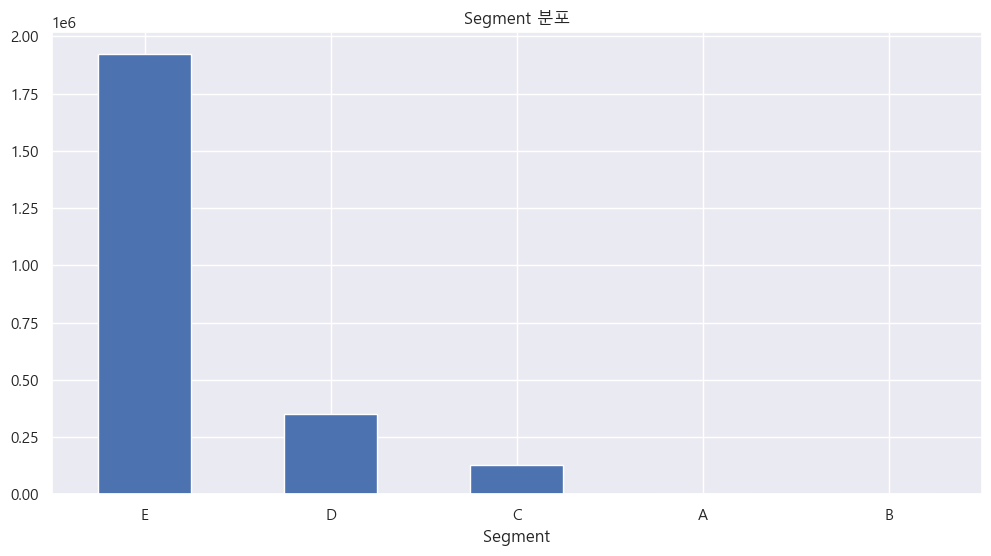

In [12]:
balance_eda['Segment'].value_counts().plot(kind='bar', title='Segment 분포', rot=0)

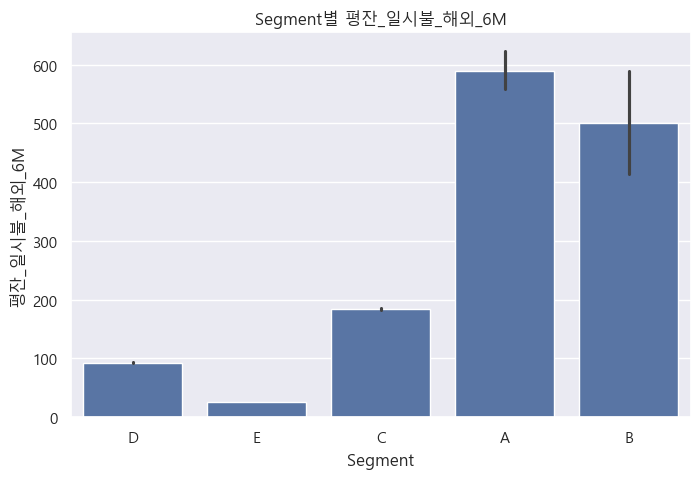

In [20]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Segment', y='평잔_일시불_해외_6M', data=balance_eda)
plt.title('Segment별 평잔_일시불_해외_6M')
plt.show()

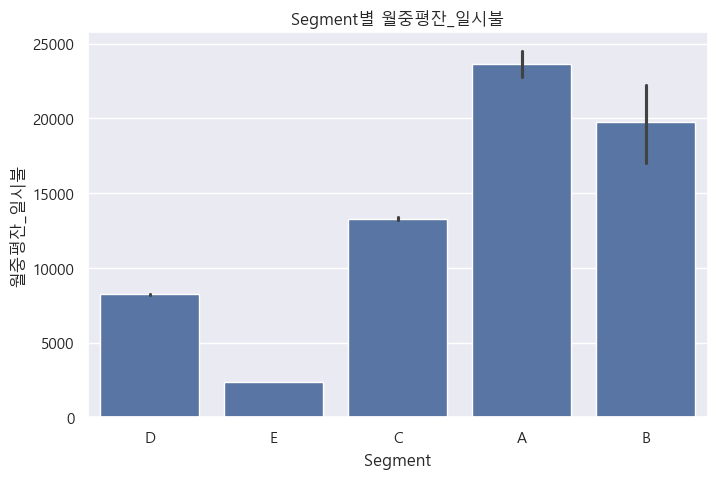

In [14]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Segment', y='월중평잔_일시불', data=balance_eda)
plt.title('Segment별 월중평잔_일시불')
plt.show()

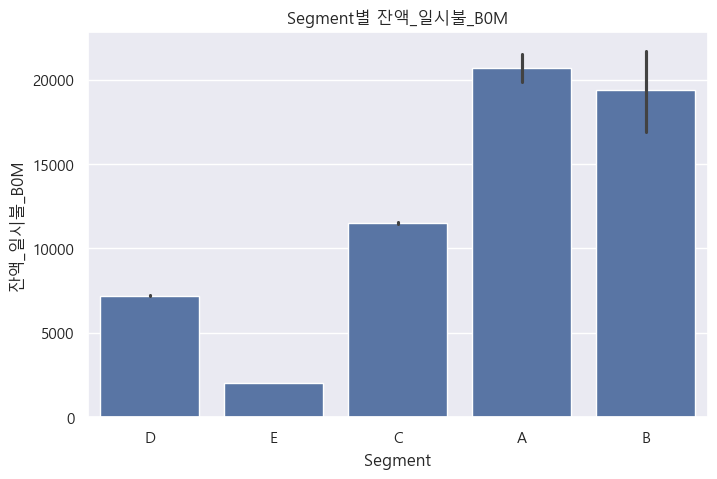

In [21]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Segment', y='잔액_일시불_B0M', data=balance_eda)
plt.title('Segment별 잔액_일시불_B0M')
plt.show()

### 컬럼을 묶어보자 . . 

#### 잔액 관련

- ex)잔액_일시불_* 컬럼들을 묶어서 컬럼을 만들고
- 컬럼이 너무 많으니, 분석을 위해 Segment를 기준으로 새로운 데이터 프레임 만들기
- 리볼빙은 묶을 수 없음
- 잔액_할부_B0M ~= 잔액_할부_유이자 + 무이자 + 해외이니 제외 

In [11]:
잔액_일시불_컬럼 = ['잔액_일시불_B0M', '잔액_일시불_B1M', '잔액_일시불_B2M'] 
잔액_할부_컬럼 = ['잔액_할부_B0M', '잔액_할부_B1M', '잔액_할부_B2M']
잔액_현금서비스_컬럼 = ['잔액_현금서비스_B0M', '잔액_현금서비스_B1M', '잔액_현금서비스_B2M']
잔액_카드론_컬럼 = ['잔액_카드론_B0M', '잔액_카드론_B1M', '잔액_카드론_B2M', '잔액_카드론_B3M', '잔액_카드론_B4M', '잔액_카드론_B5M']

# 평균 컬럼 만들기
balance_eda['잔액_일시불_전체평균'] = balance_eda[잔액_일시불_컬럼].mean(axis=1)
balance_eda['잔액_할부_전체평균'] = balance_eda[잔액_할부_컬럼].mean(axis=1)
balance_eda['잔액_현금서비스_전체평균'] = balance_eda[잔액_현금서비스_컬럼].mean(axis=1)
balance_eda['잔액_카드론_전체평균'] = balance_eda[잔액_카드론_컬럼].mean(axis=1)

In [13]:
segment_df = balance_eda.groupby('Segment')[[
    '잔액_일시불_전체평균',
    '잔액_할부_전체평균',
    '잔액_현금서비스_전체평균',
    '잔액_카드론_전체평균'
]].mean().reset_index()

In [24]:
segment_df

,잔액_일시불_전체평균,잔액_할부_전체평균,잔액_현금서비스_전체평균,잔액_카드론_전체평균
Segment,,,,
A,20155.26646,13508.32236,10008.06756,3560.75789
B,18037.89120,17619.00463,13567.09491,7223.07755
C,11723.59892,5227.91943,4652.86973,4028.40394
D,7539.20118,3265.04352,1766.72509,3931.25701
E,2154.60177,1206.66433,304.51136,2354.17252


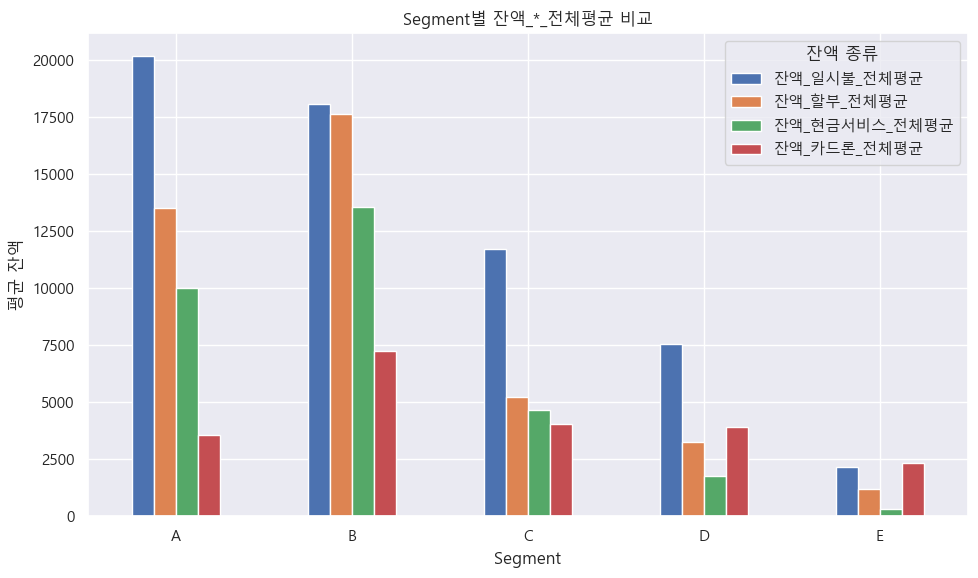

In [40]:
# 1. 세그먼트를 인덱스로 설정
segment_df.set_index('Segment', inplace=True)

# 2. 막대그래프
segment_df.plot(kind='bar', figsize=(10, 6))

plt.title('Segment별 잔액_*_전체평균 비교')
plt.xlabel('Segment')
plt.ylabel('평균 잔액')
plt.xticks(rotation=0)
plt.legend(title='잔액 종류')
plt.tight_layout()
plt.show()

- 상품군 (일시불 ,할부, 현금서비스, 카드론)별 평균 잔액 분석
- 일시불은 A , B , C , D , E 순서로 높다.
- 할부와 현금서비스는 B , A , C , D , E 순서이다.
- 카드론(대출)은 B , C , D , A , E 순서이다.

In [33]:
balance_eda[['잔액_일시불_전체평균', '잔액_할부_전체평균', '잔액_현금서비스_전체평균', '잔액_카드론_전체평균']].corr()

,잔액_일시불_전체평균,잔액_할부_전체평균,잔액_현금서비스_전체평균,잔액_카드론_전체평균
잔액_일시불_전체평균,1.00000,0.11164,0.03283,0.02878
잔액_할부_전체평균,0.11164,1.00000,0.10226,0.09308
잔액_현금서비스_전체평균,0.03283,0.10226,1.00000,0.12532
잔액_카드론_전체평균,0.02878,0.09308,0.12532,1.00000


#### 연체 관련

In [100]:
# 연체 상품군 컬럼 목록
연체_구성_컬럼 = [
    '연체잔액_일시불_B0M',
    '연체잔액_할부_B0M',
    '연체잔액_현금서비스_B0M',
    '연체잔액_카드론_B0M',
    '연체잔액_대환론_B0M'
]

# 구성 요소 합계 계산
balance_eda['연체_구성합'] = balance_eda[연체_구성_컬럼].sum(axis=1)

# 연체잔액_B0M과 일치 여부
balance_eda['연체_정확히일치'] = balance_eda['연체잔액_B0M'] == balance_eda['연체_구성합']

# 일치율 확인
print('정확히 일치하는 비율:', balance_eda['연체_정확히일치'].mean())

정확히 일치하는 비율: 0.9995508333333334


- 연체잔액_B0M에 모든게 합쳐져있음. 일시불, 할부 ,... 등 따로 봐야 의미가 있을 것 같음
- Segment별 연체잔액 평균 확인
- Segment별 연체율 확인

In [108]:
# 연체여부 컬럼 추가하기
balance_eda['연체여부'] = balance_eda['연체잔액_B0M'].apply(lambda x: 1 if x > 0 else 0)
balance_eda

,기준년월,ID,잔액_일시불_B0M,잔액_할부_B0M,잔액_현금서비스_B0M,잔액_리볼빙일시불이월_B0M,잔액_리볼빙CA이월_B0M,잔액_카드론_B0M,월중평잔_일시불_B0M,월중평잔_할부_B0M,...,평잔_카드론_6M,연체정보_유무,Segment,잔액_일시불_전체평균,잔액_할부_전체평균,잔액_현금서비스_전체평균,잔액_카드론_전체평균,연체_구성합,연체_정확히일치,연체여부
0,201807,TRAIN_000000,998,962,22971,0,0,0,1084,547,...,0,1,D,939.000000,802.333333,25160.333333,0.000000,0,True,0
1,201807,TRAIN_000001,2565,2390,0,0,0,0,4090,2553,...,0,1,E,3594.666667,2622.666667,0.000000,0.000000,0,True,0
2,201807,TRAIN_000002,5312,5113,21531,6795,0,0,5006,8778,...,0,1,C,5535.000000,6265.666667,23367.000000,0.000000,0,True,0
3,201807,TRAIN_000003,730,5025,26284,0,0,0,487,5607,...,0,0,D,633.333333,4959.333333,30288.000000,0.000000,0,True,0
4,201807,TRAIN_000004,0,0,0,0,0,0,0,0,...,0,0,E,0.000000,0.000000,0.000000,0.000000,0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,201812,TRAIN_399995,0,0,0,0,0,0,0,0,...,0,0,E,0.000000,0.000000,0.000000,0.000000,0,True,0
2399996,201812,TRAIN_399996,3351,0,0,0,0,27337,4412,0,...,23031,0,D,3951.666667,0.000000,0.000000,28389.833333,0,True,0
2399997,201812,TRAIN_399997,2524,2960,0,0,0,0,2694,3374,...,0,0,C,2315.000000,3241.666667,0.000000,0.000000,0,True,0
2399998,201812,TRAIN_399998,0,0,0,0,0,0,0,0,...,0,0,E,0.000000,0.000000,0.000000,0.000000,0,True,0


In [112]:
# 불균형 데이터인 것 같다.. 일단 넘기자
balance_eda['연체여부'].value_counts()

연체여부
0    2396459
1       3541
Name: count, dtype: int64

In [117]:
# Segment별 연체 금액 평균 및 연체율 계산
segment_df2 = balance_eda.groupby('Segment')[['연체잔액_B0M', '연체여부']].mean().reset_index()

# 컬럼명 보기 좋게 변경 (선택사항)
segment_df2.rename(columns={
    '연체잔액_B0M': '연체잔액_평균',
    '연체여부': '연체율'
}, inplace=True)

# 결과 확인
segment_df2

,Segment,연체잔액_평균,연체율
0,A,0.000000,0.000000
1,B,0.000000,0.000000
2,C,7.840270,0.001662
3,D,11.340357,0.002199
4,E,5.952704,0.001332


- A와 B는 연체를 아예 안한다고 볼 수 있음.
- 연체잔액의 평균과 연체율은 D가 제일 높음
- 그 다음 C, E 순서
- 나중에 확인해본거지만 생각해보니 C, D, E 고객들이 너무 많음

In [50]:
# Segment별 평잔 평균 계산
segment_balance_avg = balance_eda.groupby('Segment')[['평잔_3M', '평잔_6M', '월중평잔']].mean().reset_index()

# 결과 확인
segment_balance_avg

,Segment,평잔_3M,평잔_6M,월중평잔
0,A,73587.76029,81480.23765,78104.19136
1,B,81215.38194,86976.20139,88539.90972
2,C,34370.99628,37899.05279,33828.45492
3,D,21181.07111,23310.00450,20346.54838
4,E,7180.73400,7894.15721,6431.26553


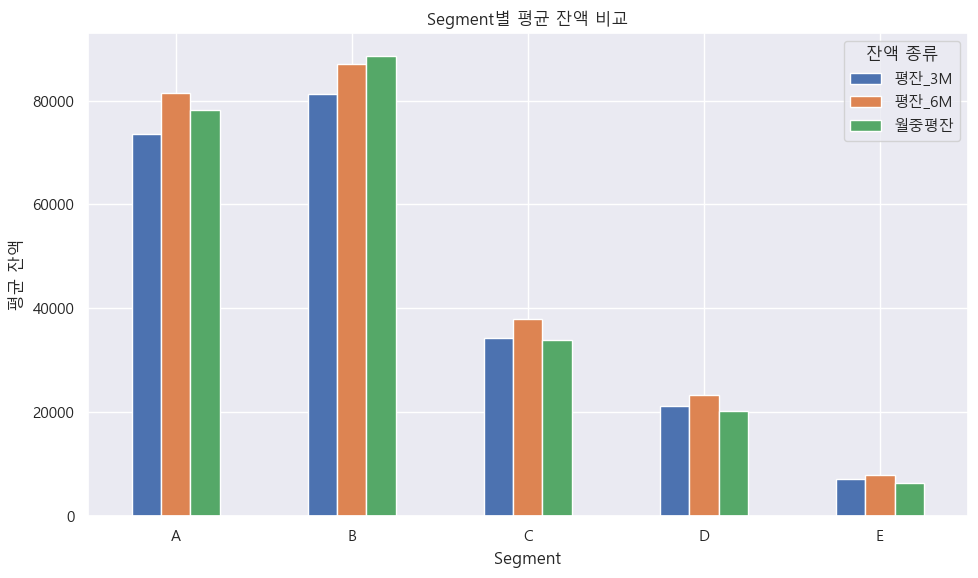

In [54]:
# 1. 세그먼트를 인덱스로 설정
segment_balance_avg.set_index('Segment', inplace=True)

# 2. 막대그래프
segment_balance_avg.plot(kind='bar', figsize=(10, 6))

plt.title('Segment별 평균 잔액 비교')
plt.xlabel('Segment')
plt.ylabel('평균 잔액')
plt.xticks(rotation=0)
plt.legend(title='잔액 종류')
plt.tight_layout()
plt.show()

- 평균 잔액 : B, A, C, D, E 순서
- 월중 평균 잔액도 같은 순서

In [141]:
# Segment별 평잔 평균 계산
segment_리볼빙 = balance_eda.groupby('Segment')[['RV_평균잔액_R12M', 'RV_최대잔액_R12M']].mean().reset_index()

# 결과 확인
segment_리볼빙

,Segment,RV_평균잔액_R12M,RV_최대잔액_R12M
0,A,562.054527,1051.531893
1,B,423.305556,1123.958333
2,C,777.886770,1250.744008
3,D,916.817058,1424.485088
4,E,321.217568,513.306368


- (1년) 리볼빙 평균 잔액 : D, C, A, B, E 순서
- (1년) 리볼빙 쵀대 잔액 : D, C, B, A, E 순서

In [163]:
# Segment별 리볼빙 잔액이월 계산
# segment_리볼빙_잔액이월 = balance_eda.groupby('Segment')[['RV잔액이월횟수_R6M', 'RV잔액이월횟수_R3M']].mean().reset_index()

#결과 확인
# segment_리볼빙_잔액이월

# 왜 없지?.. 명세서엔 있는데

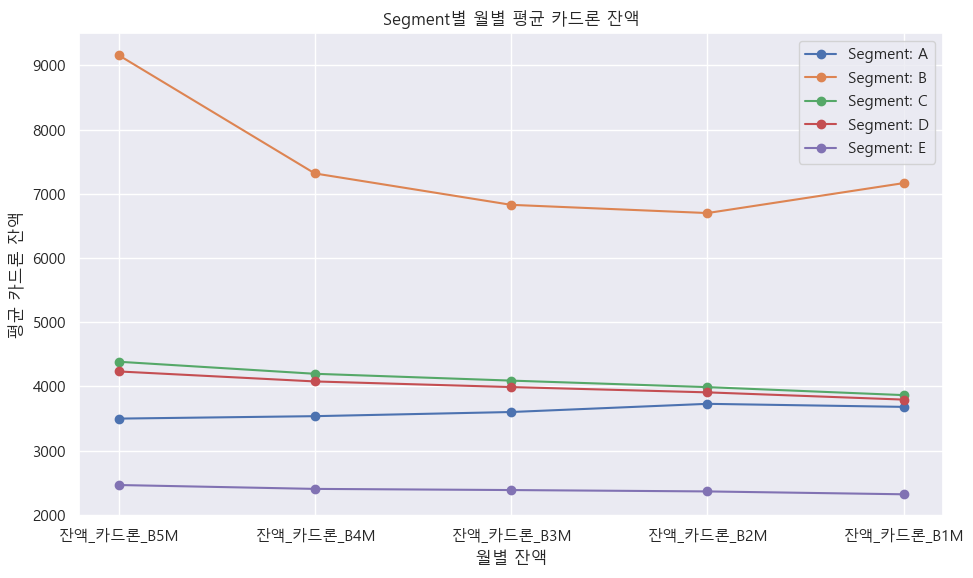

In [34]:
# 1. 월별 컬럼 지정
month_cols = ['잔액_카드론_B5M', '잔액_카드론_B4M', '잔액_카드론_B3M', '잔액_카드론_B2M', '잔액_카드론_B1M']

# 2. Segment별 평균 잔액 계산
segment_monthly_avg = balance_eda.groupby('Segment')[month_cols].mean()

# 3. 행과 열 전치 (그래프용: 월이 X축)
segment_monthly_avg = segment_monthly_avg.T

# 4. 그래프 그리기
plt.figure(figsize=(10, 6))

for segment in segment_monthly_avg.columns:
    plt.plot(segment_monthly_avg.index, segment_monthly_avg[segment], marker='o', label=f'Segment: {segment}')

plt.title('Segment별 월별 평균 카드론 잔액')
plt.xlabel('월별 잔액')
plt.ylabel('평균 카드론 잔액')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()